In [1]:
import csv
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import pandas_datareader.data as web
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from matplotlib import pyplot
import scipy.stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
%matplotlib inline

In [2]:
fpath = 'facebook_data_bloombergmarkets_post_sentiment_4dict.tsv'
post_data = pd.read_csv(fpath, sep='\t')
post_data.head()

,ID,PostID,PostDate,Text,Likes,Shares,WNPositive,WNNegative,WNNeutral,WNSentiment,...,HVTokenQnt,HVSentiAvg,LMPositive,LMNegative,LMTokenQnt,LMSentiAvg,Vader_Positive,Vader_Negative,Vader_Neutral,Vader_Compound
0,1,3847873015280995,2021-05-16 00:03:09,BREAKING: Billionaire George Soros’s investmen...,0,0,0.250,0.625,16.125,-0.375,...,24,0.041667,0,2,24,-0.083333,0.047,0.108,0.846,-0.4404
1,2,3846792925389004,2021-05-15 16:09:27,LATEST: America’s millions of unused doses are...,0,0,0.125,1.250,8.625,-1.125,...,19,0.052632,1,1,19,0.000000,0.105,0.093,0.802,0.0772
2,3,3846326078769022,2021-05-15 12:34:37,Singapore's tourism industry is racing to catc...,0,0,0.375,0.000,12.625,0.375,...,16,0.000000,0,0,16,0.000000,0.000,0.000,1.000,0.0000
3,4,3845819882152975,2021-05-15 08:30:13,Asian stocks are falling further behind their ...,0,0,0.375,1.500,10.125,-1.125,...,9,-0.444444,0,1,9,-0.111111,0.000,0.222,0.778,-0.6908
4,5,3845620125506284,2021-05-15 06:41:53,"Taiwan, seen as a model for tackling Covid, ti...",0,0,0.500,0.250,15.250,0.250,...,19,-0.052632,0,2,19,-0.105263,0.000,0.000,1.000,0.0000


In [3]:
post_data['Vader_Average'] = post_data['Vader_Positive'] - post_data['Vader_Negative']

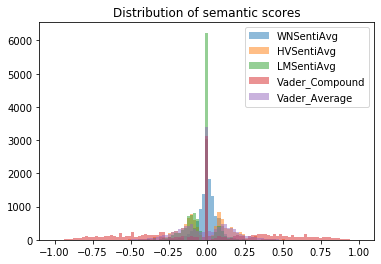

In [4]:
bins = np.linspace(-1, 1, 100)
pyplot.hist(post_data['WNSentiAvg'], bins, alpha=0.5, label='WNSentiAvg')
pyplot.hist(post_data['HVSentiAvg'], bins, alpha=0.5, label='HVSentiAvg')
pyplot.hist(post_data['LMSentiAvg'], bins, alpha=0.5, label='LMSentiAvg')
pyplot.hist(post_data['Vader_Compound'], bins, alpha=0.5, label='Vader_Compound')
pyplot.hist(post_data['Vader_Positive'] - post_data['Vader_Negative'], bins, alpha=0.5, label='Vader_Average')
pyplot.legend(loc='upper right')
pyplot.title('Distribution of semantic scores')
pyplot.show()

Text(0, 0.5, 'Posts')

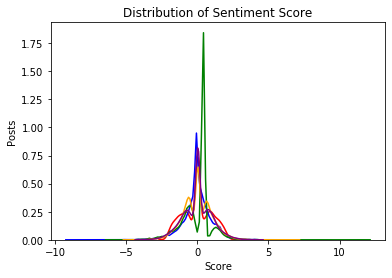

In [5]:


# seaborn histogram
sns.distplot((post_data['Vader_Compound'] - post_data['Vader_Compound'].mean())/post_data['Vader_Compound'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'red',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['WNSentiAvg'] - post_data['WNSentiAvg'].mean())/post_data['WNSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['LMSentiAvg'] - post_data['LMSentiAvg'].mean())/post_data['LMSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'green',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['HVSentiAvg'] - post_data['HVSentiAvg'].mean())/post_data['HVSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'orange',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['Vader_Average'] - post_data['Vader_Average'].mean())/post_data['Vader_Average'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'purple',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Distribution of Sentiment Score')
plt.xlabel('Score')
plt.ylabel('Posts')

In [6]:
post_data[['WNSentiAvg','HVSentiAvg','LMSentiAvg','Vader_Compound','Vader_Average']].describe()

,WNSentiAvg,HVSentiAvg,LMSentiAvg,Vader_Compound,Vader_Average
count,12274.000000,12274.000000,12274.000000,12274.000000,12274.000000
mean,0.004533,-0.005829,-0.035970,-0.013559,-0.006331
std,0.061284,0.149381,0.087688,0.435768,0.157698
min,-0.541667,-0.714286,-0.571429,-0.975300,-0.624000
25%,-0.020833,-0.100000,-0.083333,-0.340000,-0.107000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.035714,0.090909,0.000000,0.318200,0.093000
max,0.410714,1.000000,1.000000,0.984200,0.652000


In [7]:
post_data['PostDate'] = pd.to_datetime(post_data['PostDate'], errors='coerce')

post_data['DateMonth'] = post_data['PostDate'].dt.strftime('%Y-%m')
post_data['DateDay'] = post_data['PostDate'].dt.strftime('%Y-%m-%d')

In [8]:
post_data['DateMonth'].head()

0    2021-05
1    2021-05
2    2021-05
3    2021-05
4    2021-05
Name: DateMonth, dtype: object

In [9]:
post_data.columns

Index(['ID', 'PostID', 'PostDate', 'Text', 'Likes', 'Shares', 'WNPositive',
       'WNNegative', 'WNNeutral', 'WNSentiment', 'WNTokenQnt', 'WNSentiAvg',
       'HVPositive', 'HVNegative', 'HVTokenQnt', 'HVSentiAvg', 'LMPositive',
       'LMNegative', 'LMTokenQnt', 'LMSentiAvg', 'Vader_Positive',
       'Vader_Negative', 'Vader_Neutral', 'Vader_Compound', 'Vader_Average',
       'DateMonth', 'DateDay'],
      dtype='object')

In [10]:
Monthly_Data = post_data.groupby('DateMonth').agg({'WNSentiAvg': 'sum'
                                                         ,'WNTokenQnt':'count'
                                                        ,'Vader_Compound':'mean'
                                                        ,'Vader_Average': 'mean'
                                                        ,'HVPositive':'sum'
                                                        ,'HVNegative':'sum'
                                                        ,'HVTokenQnt':'sum'
                                                        ,'LMPositive':'sum'
                                                        ,'LMNegative':'sum'
                                                        ,'LMTokenQnt':'sum'
                                                       })

In [11]:
DailyData = post_data.groupby('DateDay').agg({'WNSentiAvg': 'sum'
                                                        ,'WNTokenQnt':'count'
                                                        ,'Vader_Compound':'mean'
                                                        ,'Vader_Average': 'mean'
                                                        ,'HVPositive':'sum'
                                                        ,'HVNegative':'sum'
                                                        ,'HVTokenQnt':'sum'
                                                        ,'LMPositive':'sum'
                                                        ,'LMNegative':'sum'
                                                        ,'LMTokenQnt':'sum'
                                                        })

In [12]:
DailyData['WNSentiment'] =  DailyData['WNSentiAvg']/ DailyData['WNTokenQnt']
DailyData['HVSentiment'] = (DailyData['HVPositive'] - DailyData['HVNegative'])/DailyData['HVTokenQnt']
DailyData['LMSentiment'] = (DailyData['LMPositive'] - DailyData['LMNegative'])/DailyData['LMTokenQnt']

Monthly_Data['WNSentiment'] =  Monthly_Data['WNSentiAvg']/ Monthly_Data['WNTokenQnt']
Monthly_Data['HVSentiment'] = (Monthly_Data['HVPositive'] - Monthly_Data['HVNegative'])/Monthly_Data['HVTokenQnt']
Monthly_Data['LMSentiment'] = (Monthly_Data['LMPositive'] - Monthly_Data['LMNegative'])/Monthly_Data['LMTokenQnt']



In [13]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['WNSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -6.6105
p-value                           0.0000
#Lags Used                       27.0000
Number of Observations Used    2709.0000
Critical Value (1%)              -3.4328
Critical Value (5%)              -2.8626
Critical Value (10%)             -2.5673
dtype: float64


In [14]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['HVSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -6.5368
p-value                           0.0000
#Lags Used                       25.0000
Number of Observations Used    2711.0000
Critical Value (1%)              -3.4328
Critical Value (5%)              -2.8626
Critical Value (10%)             -2.5673
dtype: float64


In [15]:
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['LMSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value


Test Statistic                   -6.5368
p-value                           0.0000
#Lags Used                       25.0000
Number of Observations Used    2711.0000
Critical Value (1%)              -3.4328
Critical Value (5%)              -2.8626
Critical Value (10%)             -2.5673
dtype: float64
Results of Dickey-Fuller Test:


In [16]:
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['Vader_Compound'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value


Test Statistic                   -5.1957
p-value                           0.0000
#Lags Used                       28.0000
Number of Observations Used    2708.0000
Critical Value (1%)              -3.4328
Critical Value (5%)              -2.8626
Critical Value (10%)             -2.5673
dtype: float64
Results of Dickey-Fuller Test:


In [17]:
DailyData.head()

,WNSentiAvg,WNTokenQnt,Vader_Compound,Vader_Average,HVPositive,HVNegative,HVTokenQnt,LMPositive,LMNegative,LMTokenQnt,WNSentiment,HVSentiment,LMSentiment
DateDay,,,,,,,,,,,,,
2011-06-17,0.000000,4,0.124575,0.0330,3,1,50,1,0,50,0.000000,0.040000,0.020000
2011-06-20,0.187500,1,0.636900,0.3180,2,0,5,0,0,5,0.187500,0.400000,0.000000
2011-06-21,0.000000,2,-0.411250,-0.0945,1,3,31,0,0,31,0.000000,-0.064516,0.000000
2011-06-22,0.086538,2,0.461400,0.1830,0,2,15,0,0,15,0.043269,-0.133333,0.000000
2011-06-23,0.000613,2,0.473450,0.1575,5,3,28,0,1,28,0.000306,0.071429,-0.035714


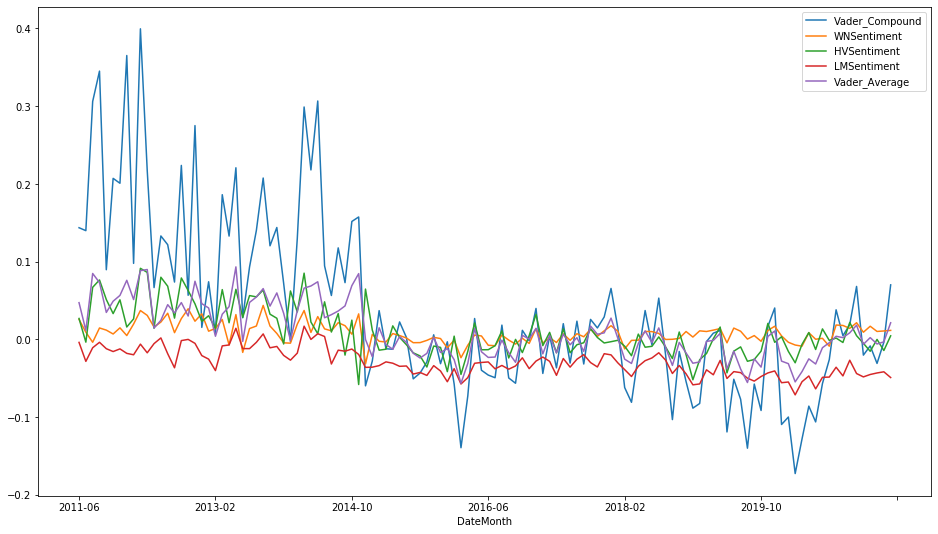

In [18]:
Monthly_Data[['Vader_Compound','WNSentiment','HVSentiment','LMSentiment','Vader_Average']].plot(legend=True, figsize=(16,9))

## Download S&P from Yahoo

In [19]:
SnP_daily = web.get_data_yahoo('^GSPC','01/01/2010','05/01/2021',interval='d')
SnP_monthly = web.get_data_yahoo('^GSPC','01/01/2010','05/01/2021',interval='m')

In [20]:
SnP_daily['LogReturn'] = np.log(SnP_daily['Adj Close']/SnP_daily['Adj Close'].shift(1))

In [21]:
SnP_monthly.index = SnP_monthly.index.strftime('%Y-%m')

In [22]:
SnP_monthly['LogReturn'] = np.log(SnP_monthly['Adj Close']/SnP_monthly['Adj Close'].shift(1))

## Granger test

In [23]:
Granger_data_daily = pd.merge(SnP_daily,DailyData, how= 'inner', left_index=True, right_index=True)

In [24]:
def grangerTest(exog, endog):
    MAX_LAG = 30
    ARaic = AR(exog.tolist()).fit(maxlag=MAX_LAG, ic="aic")
    ARbic = AR(exog.tolist()).fit(maxlag=MAX_LAG, ic="bic")
    # select the fewer number of parameters between both criteria.
    numExog = len(ARaic.params) if len(ARaic.params) < len(ARbic.params) else len(ARbic.params)

    print ("Optimal number of lags for exog data is " + str(numExog))

    ARaic = AR(endog.tolist()).fit(maxlag=MAX_LAG, ic="aic")
    ARbic = AR(endog.tolist()).fit(maxlag=MAX_LAG, ic="bic")
    # select the fewer number of parameters between both criteria.
    numEndog = len(ARaic.params) if len(ARaic.params) < len(ARbic.params) else len(ARbic.params)

    print ("Optimal number of lags for endog data is " + str(numEndog))

    # now that I know the optimal number of parameters, I can call the
    # granger causality function of statsmodels.
    data = pd.concat([endog, exog], axis=1)
    print ("\nGranger causality results of indep onto dep")
    results = grangercausalitytests(data, maxlag=numEndog)

    data = pd.concat([exog, endog], axis=1)
    print ("\nGranger causality results of dep onto indep")
    results = grangercausalitytests(data, maxlag=numExog)
    regr = results[2][1]
    print (regr[0].params)
    print (regr[1].params)
    print (regr[1].pvalues)

In [25]:
Granger_data_monthly = pd.merge(SnP_monthly,Monthly_Data, how= 'inner', left_index=True, right_index=True)

In [26]:
#Granger_data['SS_LogReturn'] = np.log((Granger_data['SentimentScoreAdj']+1)/(Granger_data['SentimentScoreAdj']+1).shift(1))

In [27]:
Vars = ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"]
for Var in Vars:
    print("\n" + Var + "\n")
    grangerTest(Granger_data_daily[Var], Granger_data_daily['LogReturn'])


Vader_Compound



C:\Users\Windows\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


Optimal number of lags for exog data is 4
Optimal number of lags for endog data is 10

Granger causality results of indep onto dep

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9843  , p=0.3213  , df_denom=2163, df_num=1
ssr based chi2 test:   chi2=0.9857  , p=0.3208  , df=1
likelihood ratio test: chi2=0.9854  , p=0.3209  , df=1
parameter F test:         F=0.9843  , p=0.3213  , df_denom=2163, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4664  , p=0.6273  , df_denom=2160, df_num=2
ssr based chi2 test:   chi2=0.9349  , p=0.6266  , df=2
likelihood ratio test: chi2=0.9347  , p=0.6267  , df=2
parameter F test:         F=0.4664  , p=0.6273  , df_denom=2160, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5504  , p=0.6479  , df_denom=2157, df_num=3
ssr based chi2 test:   chi2=1.6567  , p=0.6466  , df=3
likelihood ratio test: chi2=1.6561  , p=0.6467  , df=3
parameter F test:         F=0.5

Optimal number of lags for exog data is 4
Optimal number of lags for endog data is 10

Granger causality results of indep onto dep

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5562  , p=0.4559  , df_denom=2163, df_num=1
ssr based chi2 test:   chi2=0.5570  , p=0.4555  , df=1
likelihood ratio test: chi2=0.5569  , p=0.4555  , df=1
parameter F test:         F=0.5562  , p=0.4559  , df_denom=2163, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8843  , p=0.4132  , df_denom=2160, df_num=2
ssr based chi2 test:   chi2=1.7726  , p=0.4122  , df=2
likelihood ratio test: chi2=1.7719  , p=0.4123  , df=2
parameter F test:         F=0.8843  , p=0.4132  , df_denom=2160, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5934  , p=0.1890  , df_denom=2157, df_num=3
ssr based chi2 test:   chi2=4.7956  , p=0.1874  , df=3
likelihood ratio test: chi2=4.7903  , p=0.1878  , df=3
parameter F test:         F=1.5

Optimal number of lags for exog data is 8
Optimal number of lags for endog data is 10

Granger causality results of indep onto dep

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3546  , p=0.2446  , df_denom=2163, df_num=1
ssr based chi2 test:   chi2=1.3565  , p=0.2441  , df=1
likelihood ratio test: chi2=1.3561  , p=0.2442  , df=1
parameter F test:         F=1.3546  , p=0.2446  , df_denom=2163, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6321  , p=0.5316  , df_denom=2160, df_num=2
ssr based chi2 test:   chi2=1.2671  , p=0.5307  , df=2
likelihood ratio test: chi2=1.2668  , p=0.5308  , df=2
parameter F test:         F=0.6321  , p=0.5316  , df_denom=2160, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2774  , p=0.2805  , df_denom=2157, df_num=3
ssr based chi2 test:   chi2=3.8446  , p=0.2787  , df=3
likelihood ratio test: chi2=3.8412  , p=0.2791  , df=3
parameter F test:         F=1.2

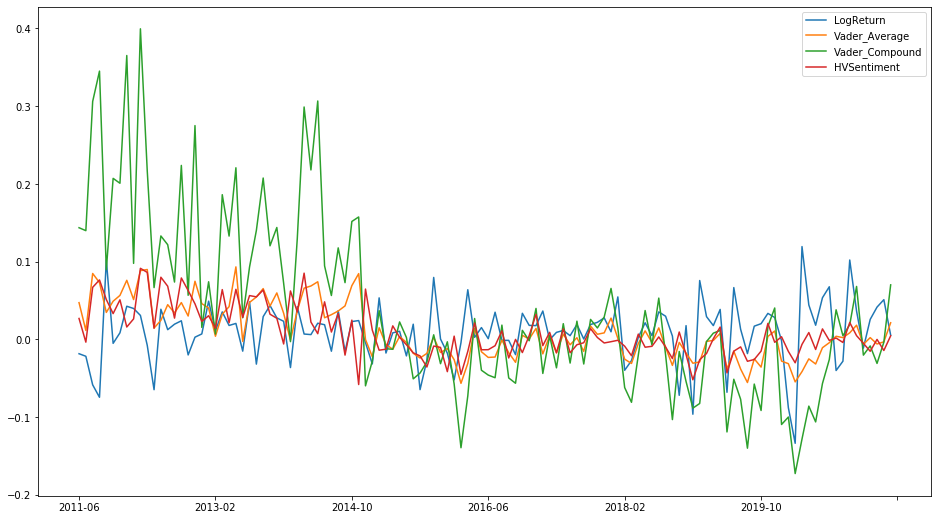

In [28]:
Granger_data_monthly[['LogReturn','Vader_Average','Vader_Compound','HVSentiment']].plot(legend=True, figsize=(16,9))

In [30]:
corr = Granger_data_daily[["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment", 'LogReturn']].corr()
corr.style.background_gradient(cmap='coolwarm')

,Vader_Compound,Vader_Average,WNSentiment,HVSentiment,LMSentiment,LogReturn
Vader_Compound,1.000000,0.921830,0.357260,0.442596,0.462694,0.019388
Vader_Average,0.921830,1.000000,0.373643,0.440092,0.466188,0.012869
WNSentiment,0.357260,0.373643,1.000000,0.257678,0.265665,0.032583
HVSentiment,0.442596,0.440092,0.257678,1.000000,0.508136,0.036257
LMSentiment,0.462694,0.466188,0.265665,0.508136,1.000000,0.017706
LogReturn,0.019388,0.012869,0.032583,0.036257,0.017706,1.000000


In [31]:
pvals = [] 
for col in ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"]:
    pvals.append(scipy.stats.linregress(Granger_data_daily['LogReturn'][1:], Granger_data_daily[col][1:].dropna())[3])
corr_signif = pd.DataFrame(pvals,columns = ['p-value']
                           ,index = ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"])
#print(corr_signif.to_latex())
print(corr_signif)

                 p-value
Vader_Compound  0.368055
Vader_Average   0.550431
WNSentiment     0.129251
HVSentiment     0.091979
LMSentiment     0.412993


In [38]:
pvals_mnt = [] 
for col in ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average']:
    pvals_mnt.append(scipy.stats.linregress(Granger_data_monthly['LogReturn'][1:], Granger_data_monthly[col][1:].dropna())[3])
corr_signif_mnt = pd.DataFrame(pvals_mnt,columns = ['p-value']
                           ,index = ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average'])
corr_signif_mnt

,p-value
Vader_Compound,0.084306
Flair_Score,0.977764
SentimentScoreAdj,0.311650
Vader_Average,0.047369
